In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
class NonStationaryBandit:
    def __init__(self, n_arms=10, initial_value=5, random_walk_std=0.01):
        self.n_arms = n_arms
        self.q_true = np.full(n_arms, initial_value, dtype=float)
        self.random_walk_std = random_walk_std

    def pull(self, action):
        reward = np.random.normal(self.q_true[action], 1)
        self.q_true += np.random.normal(0, self.random_walk_std, self.n_arms)

        return reward

In [3]:
class Agent:
    def __init__(self, n_arms, epsilon=0.1, alpha=0.1, window_size=100):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.window_size = window_size
        self.q_estimates = np.full(n_arms, 5)
        self.action_counts = np.zeros(n_arms)
        self.recent_rewards = np.zeros(window_size)
        self.recent_rewards_idx = 0

    def choose_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        else:
            return np.argmax(self.q_estimates)

    def update(self, action, reward):
        self.action_counts[action] += 1
        self.recent_rewards[self.recent_rewards_idx] = reward
        self.recent_rewards_idx = (self.recent_rewards_idx + 1) % self.window_size

        mean_reward = self.recent_rewards.mean()
        variance = self.recent_rewards.var()
        self.q_estimates[action] += self.alpha * (reward - mean_reward) / (1e-10 + np.sqrt(variance))

        self.epsilon = max(0.01, self.epsilon * 0.999)
        self.alpha = max(0.01, self.alpha * 0.999)

In [4]:
def run_single_experiment(run):
    n_steps = 10000
    bandit = NonStationaryBandit()
    agent = Agent(bandit.n_arms)

    rewards = np.zeros(n_steps)
    optimal_actions = np.zeros(n_steps, dtype=int)

    for step in range(n_steps):
        action = agent.choose_action()
        reward = bandit.pull(action)
        agent.update(action, reward)

        rewards[step] = reward
        optimal_actions[step] = int(action == np.argmax(bandit.q_true))

    return rewards, optimal_actions

In [5]:
def run_experiment(n_runs=100):
    with Pool() as pool:
        results = list(tqdm(pool.imap(run_single_experiment, range(n_runs)), total=n_runs))

    rewards = np.array([result[0] for result in results])
    optimal_actions = np.array([result[1] for result in results])

    return rewards, optimal_actions

100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


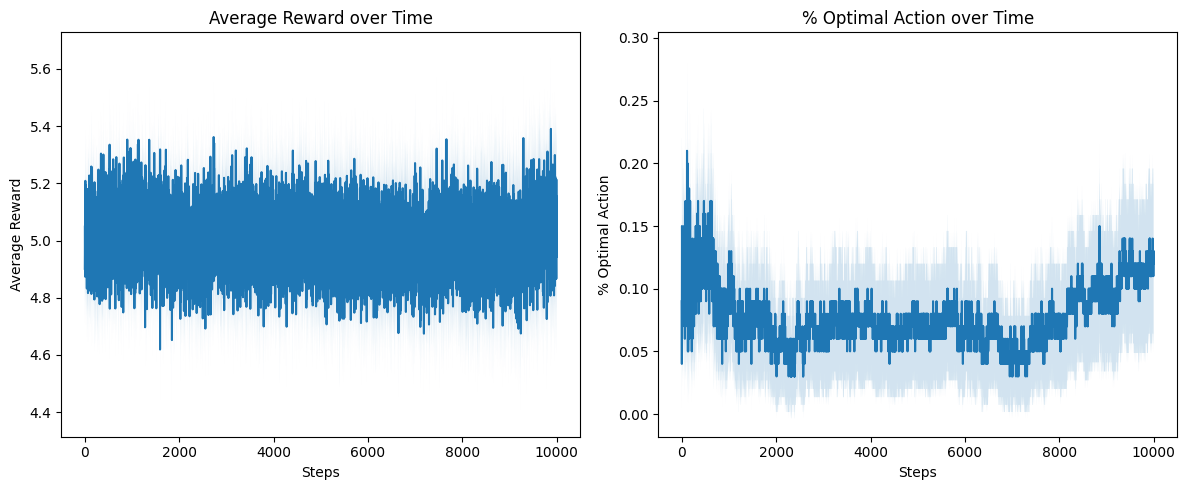

In [6]:
def plot_results(rewards, optimal_actions):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rewards.mean(axis=0))
    plt.fill_between(
        np.arange(len(rewards.mean(axis=0))),
        rewards.mean(axis=0) - 1.96 * rewards.std(axis=0) / np.sqrt(100),
        rewards.mean(axis=0) + 1.96 * rewards.std(axis=0) / np.sqrt(100),
        alpha=0.2
    )
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Time')

    plt.subplot(1, 2, 2)
    plt.plot(optimal_actions.mean(axis=0))
    plt.fill_between(
        np.arange(len(optimal_actions.mean(axis=0))),
        optimal_actions.mean(axis=0) - 1.96 * optimal_actions.std(axis=0) / np.sqrt(100),
        optimal_actions.mean(axis=0) + 1.96 * optimal_actions.std(axis=0) / np.sqrt(100),
        alpha=0.2
    )
    plt.xlabel('Steps')
    plt.ylabel('% Optimal Action')
    plt.title('% Optimal Action over Time')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    rewards, optimal_actions = run_experiment()
    plot_results(rewards, optimal_actions)